# TALLER Clase 16 - Multicolinealidad

Alejandro Mantilla Redondo - 201711304

Ximena Palacio Argüello - 201730995

En la base de datos adjunta (`diabetes.txt`), se mide el índice de glicemia ($Y$) en función de $3$ variables:

- consumo promedio semanal de kilocalorías ($X1$),
- horas semenales de ejercicio ($X2$),
- y gasto semanal de calorías ($X3$). 

No se preocupe por las unidades.

In [1]:
data <- read.table("Archivos/diabetes.txt", head = TRUE)
head(data)

,x1,x2,x3,y
,<dbl>,<dbl>,<dbl>,<dbl>
1,11.606388,22.48555,24.43439,55.383524
2,7.100081,13.42065,41.85494,5.942903
3,13.502374,27.61742,16.95941,80.365798
4,17.057526,33.71953,12.24837,103.897950
5,12.912375,23.47505,20.89624,58.774471
6,13.536525,29.51180,18.19033,89.063619


1. Estime los parámetros $\beta$ y determine cuáles de ellos son marginalmente significativos (pruebas $t$).

In [2]:
y  <- as.matrix(data$y, ncol = 1)
x1 <- as.matrix(data$x1, ncol = 1)
x2 <- as.matrix(data$x2, ncol = 1)
x3 <- as.matrix(data$x3, ncol = 1)

#Estimación de los Betas
X <- cbind(1, x1, x2, x3)
XTX <- t(X) %*% X
beta <- solve(XTX) %*% t(X) %*% y

#Cuales betas son marginalmente significativos. 
fit <- lm(y ~ x1 + x2 + x3, data = data)
summary(fit)



Call:
lm(formula = y ~ x1 + x2 + x3, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.3879 -3.0560 -0.0921  3.0800  9.9467 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.07458    9.25446  -0.008    0.994    
x1           0.98200    0.70296   1.397    0.165    
x2           3.06824    0.28722  10.683  < 2e-16 ***
x3          -0.98235    0.14958  -6.567 1.85e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.27 on 108 degrees of freedom
Multiple R-squared:  0.9803,	Adjusted R-squared:  0.9797 
F-statistic:  1789 on 3 and 108 DF,  p-value: < 2.2e-16


Para un modelo convencional, con intercepto: no rechazamos las hipótesis marginales de que $\beta_0 = 0$ y el $\beta_{x_{1}} = 0$, con un $\alpha = 0.05$.

2. ¿Cree que existen problemas de multicolinealidad?

Loading required package: carData



x1       x2       x3 
25.41865 17.35026 12.07504

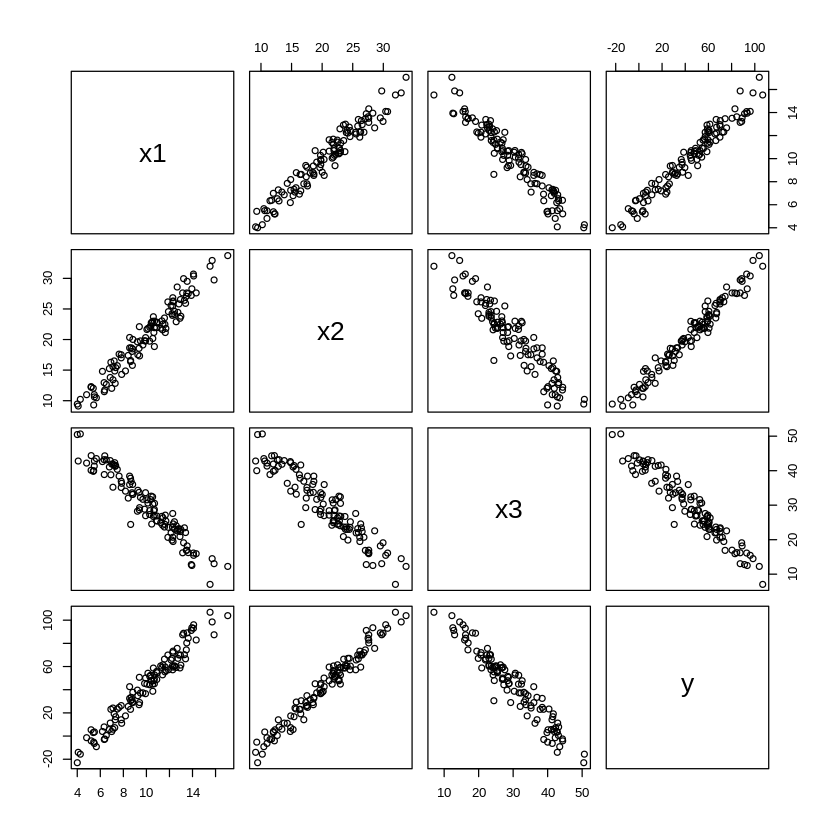

In [3]:
library(car)

pairs(data)
vif(fit)


A nuestro criterio el VIF de $X_{1}$, que nos da $25.4$, es muy alto e implica un factor elevado de la varianza del $\beta$ correspondiente. Esto indicativo suficiente de que el modelo tiene problemas de multicolinealidad. Ademas, los resultados obtenidos en la gráfica, donde se evidencia multicolinealidad entre todos los pares de variables, nos permite identifica una alta correlación entre las variables (tanto positiva como negativa).

3. Estime los parámetros $\beta$ usando penalización tipo Ridge con el $\lambda$ que considere más apropiado. Recuerde que los datos se deben centrar y estandarizar.

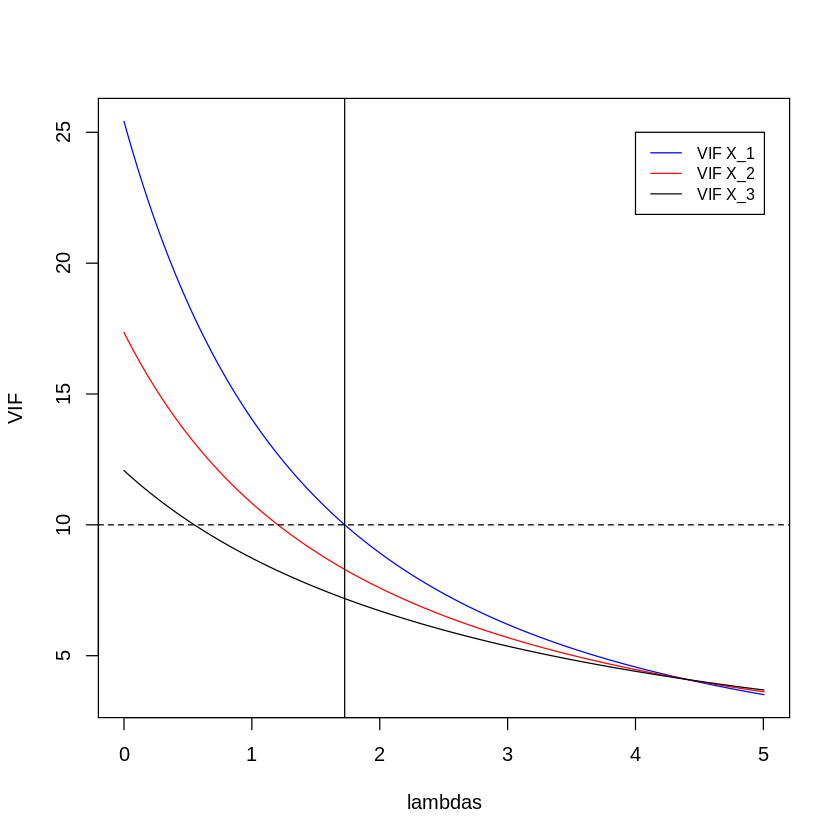

In [4]:
X <- cbind(x1, x2, x3)

#Ridge Regression
Xs <- scale(X, center = TRUE, scale = TRUE)
n <- length(y)
ys <- y - mean(y)

XsTXs <- t(Xs) %*% Xs

Hs <- solve(XsTXs)

betas <- Hs %*% t(Xs) %*% ys

#MSE=sum((ys-xs%*%betas)^2)/n-3

#Voy a utilizar el estimador tipo Ridge

lambda <- 0
lambdas <- vector()

VIF_lambda <- vector()

lambda_def <- 0

for(i in 0:1000){
    
    lambda <- lambda + i / 100000
    lambdas <- c(lambdas, lambda)
    
    beta_R <- solve(XsTXs + diag(rep(lambda, 3))) %*% t(Xs) %*% ys

    var_beta_no_s <- (solve(XsTXs + diag(rep(lambda, 3)))
                      %*% XsTXs %*% solve(XsTXs + diag(rep(lambda, 3))))

    new_VIF <- diag(var_beta_no_s) * (n - 1)
    
    VIF_lambda <- cbind(VIF_lambda, new_VIF)
    
    if(sum(new_VIF >= 10)){
        lambda_def <- lambda
    }
    
}

plot(lambdas, VIF_lambda[1,], type = "l", col = "blue", ylab = "VIF")
lines(lambdas, VIF_lambda[2,], col = "red")
lines(lambdas, VIF_lambda[3,], col = "black")
abline(10, 0, lty = 2)
abline(v = lambda_def)
legend(4, 25, legend = c("VIF X_1", "VIF X_2", "VIF X_3"),
       col = c("blue", "red", "black"), lty = 1, cex = 0.8)


El lambda a partir del cual todos los VIF son menores a 10 es: 1.72578.

In [5]:
beta_R <- solve(XsTXs + diag(rep(lambda_def, 3))) %*% t(Xs) %*% ys
beta_R

5.664391
15.437419
-8.852760


Note que estos $\hat{\beta}$ reflejan el efecto de las variables escaladas y centradas.

4. Calcule un intervalo de confianza al $95\%$ para el efecto de las horas semanales de ejercicio sobre el índice de glicemia en las unidades originales (antes de escalar).

Calculamos el intervalo de confianza por la técnica de muestreo _bootstrap_. El efecto lo calculamos a partir de regresión ridge con un $\lambda = 1.72578$.

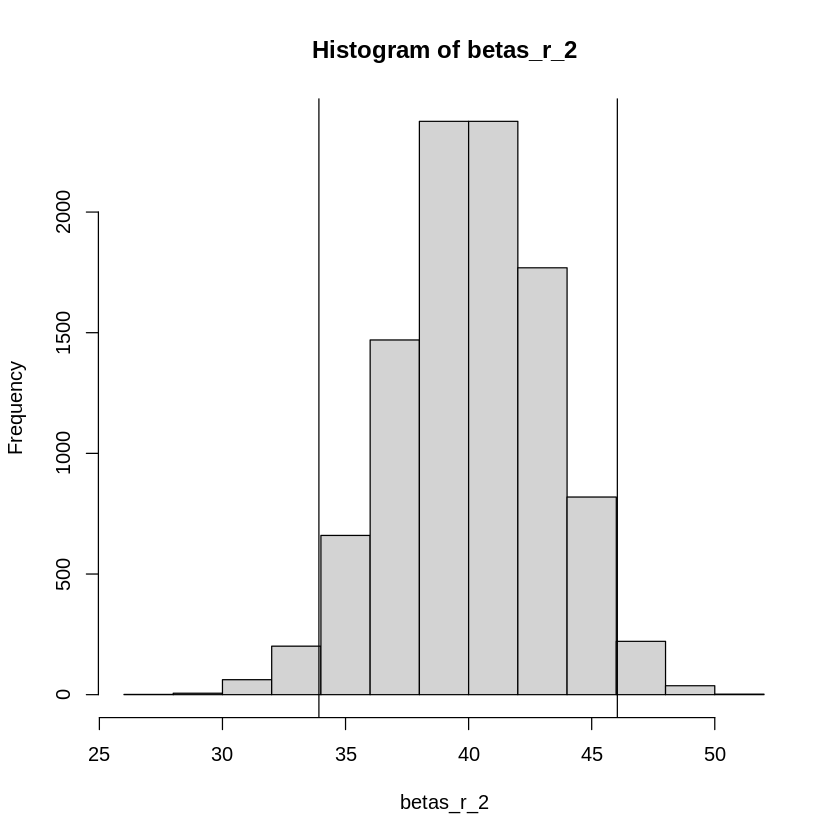

In [6]:
sample_size <- 50

num_iter <- 10000

betas_r_2 <- vector()

X <- cbind(data$x1, data$x2, data$x3)

Xs <- scale(X, center = TRUE, scale = TRUE)
ys <- y - mean(y)

for(i in 1:num_iter){
    
    rows <- sample(nrow(data), sample_size)
    
    X_new_sample <- Xs[rows, ]
    
    y_new_sample <- ys[rows, ]
    
    XsTXs <- t(X_new_sample) %*% X_new_sample
    
    
    beta_R <- solve(XsTXs + diag(rep(lambda_def, 3))) %*% t(X_new_sample) %*% y_new_sample
    
    betas_r_2 <- c(betas_r_2, beta_R[2])
}


betas_r_2 <- sqrt(sum((X[, 1] - mean(X[, 1]))^2) / (n - 1)) * betas_r_2

IC <- quantile(betas_r_2, c(2.5 / 100, 97.5 / 100))

hist(betas_r_2)
abline(v = IC[1])
abline(v = IC[2])

In [7]:
quantile(betas_r_2, c(2.5 / 100, 97.5 / 100))

2.5%    97.5% 
33.91803 46.04188

Por medio de bootstrapping, afirmamos que el valor de $\hat{\beta}_{x_{2}}$ cae en este intervalo el 95% de las muestras.